In [1]:
from keypoint_dataset import KeypointDataset
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm
import torch
import numpy as np

In [51]:
datasetPath = "/home/giorgio6846/Code/Sign-AI/data/dataset1.hdf5"
kd = KeypointDataset(datasetPath, return_label=True, max_length=20000000000)



In [52]:
len(kd)

12837

---

In [4]:
minValue = float('inf')
maxValue = float('-inf')
lengths = []

for idx in tqdm(range(len(kd)), desc="Analizando longitudes"):
    keypoints_frames = kd[idx][0].shape[0]  # cantidad de frames
    lengths.append(keypoints_frames)
    minValue = min(keypoints_frames, minValue)
    maxValue = max(keypoints_frames, maxValue)

print(f"Min length: {minValue} frames")
print(f"Max length: {maxValue} frames")
print(f"Promedio: {sum(lengths)/len(lengths):.2f} frames")


Analizando longitudes: 100%|██████████| 12738/12738 [01:10<00:00, 181.34it/s]

Min length: 2 frames
Max length: 4962 frames
Promedio: 260.53 frames


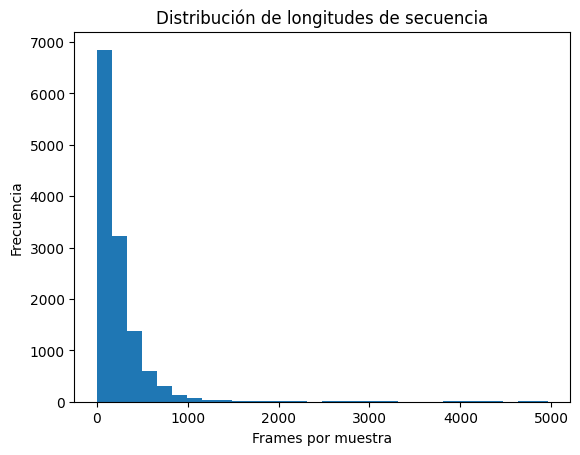

In [53]:

plt.hist(lengths, bins=30)
plt.title("Distribución de longitudes de secuencia")
plt.xlabel("Frames por muestra")
plt.ylabel("Frecuencia")
plt.show()


Sugerencia: usar max_seq_len = 690 cubre el 95% de los clips


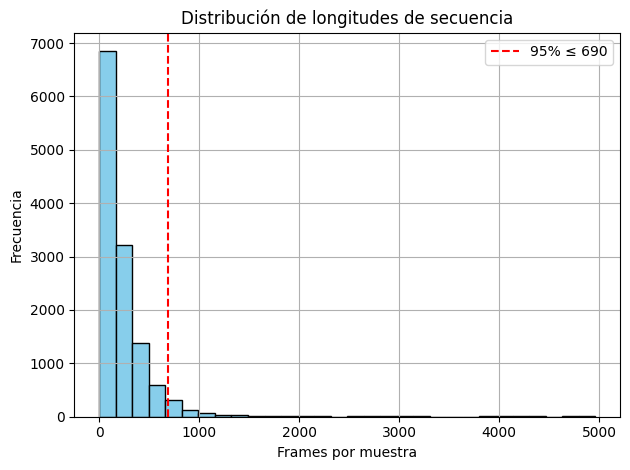

In [55]:
# Percentil 95 para decidir max_seq_len sin truncar tanto
p95 = int(np.percentile(lengths, 95))
print(f"Sugerencia: usar max_seq_len = {p95} cubre el 95% de los clips")

# Visualización
plt.hist(lengths, bins=30, color='skyblue', edgecolor='black')
plt.axvline(p95, color='red', linestyle='--', label=f'95% ≤ {p95}')
plt.title("Distribución de longitudes de secuencia")
plt.xlabel("Frames por muestra")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---

In [7]:
keypoints = kd[4000][0].clone()
keypoints.shape



torch.Size([222, 250, 2])

In [8]:
def filter_keypoints_preserve_indices(keypoints, keep_n=230, preserve_idx=None):
    """
    Filtra keypoints por varianza temporal, preservando algunos índices.

    Args:
        keypoints: Tensor (T, N, 2)
        keep_n: número total de keypoints que quieres conservar
        preserve_idx: lista de índices que siempre deben conservarse (ej. manos, rostro)

    Returns:
        filtered: Tensor (T, N, 2) con puntos fuera de la máscara puestos en 0
        final_mask: Tensor (N,) booleano indicando puntos válidos
    """
    T, N, _ = keypoints.shape
    if preserve_idx is None:
        preserve_idx = []

    # Calcula varianza por keypoint (temporalmente)
    var = keypoints.var(dim=0).mean(dim=1)  # (N,)

    # Los que ya están preservados
    preserve_mask = torch.zeros(N, dtype=torch.bool)
    preserve_mask[preserve_idx] = True

    # De los que NO están preservados, ordena por varianza
    num_to_select = max(keep_n - len(preserve_idx), 0)
    rest_idx = [i for i in range(N) if i not in preserve_idx]
    rest_var = var[rest_idx]
    _, top_rest_idx = torch.topk(-rest_var, k=num_to_select)  # -var para menor varianza
    selected_rest = [rest_idx[i.item()] for i in top_rest_idx]

    # Unión de preservados + seleccionados
    final_mask = torch.zeros(N, dtype=torch.bool)
    final_mask[preserve_idx] = True
    final_mask[selected_rest] = True

    # Aplicar la máscara
    filtered = keypoints.clone()
    for i in range(N):
        if not final_mask[i]:
            filtered[:, i] = 0

    return filtered, final_mask


In [9]:
f_keypoint = filter_keypoints_preserve_indices(keypoints,)

f_keypoint = keypoints

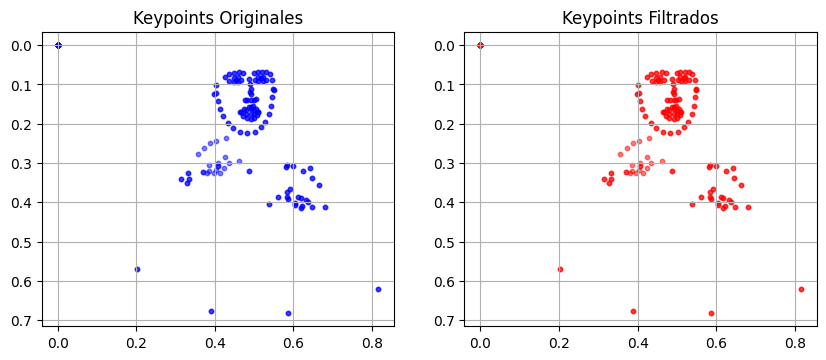

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # ax será ahora un array con 2 elementos
ax[0].set_title('Keypoints Originales')
ax[1].set_title('Keypoints Filtrados')

sc1 = ax[0].scatter(keypoints[0, :, 0], keypoints[0, :, 1], s=10, c='blue', alpha=0.5)
sc2 = ax[1].scatter(f_keypoint[0, :, 0], f_keypoint[0, :, 1], s=10, c='red', alpha=0.5)
for a in ax:
    #ax.set_xlim(0, 1)
    #ax.set_ylim(0, 1)
    a.grid(True)
    a.set_aspect('equal')
    a.invert_yaxis()  # Invertir eje Y para que coincida con la convención de coordenadas

In [11]:
def update(frame):
    points = keypoints[frame]
    filtered_points = f_keypoint[frame]
    sc1.set_offsets(points)
    sc2.set_offsets(filtered_points)
    ax[0].set_title(f'Frame {frame} - Original')
    ax[1].set_title(f'Frame {frame} - Filtrado')
    return sc1, sc2

In [12]:
anim = FuncAnimation(fig, update, frames=keypoints.shape[0], interval=50, blit=True)
HTML(anim.to_jshtml())

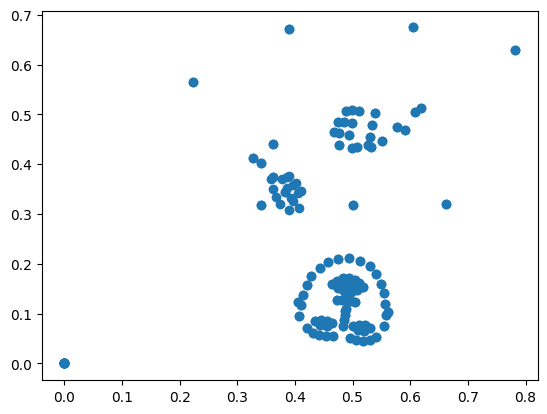

In [13]:
mean_kp = keypoints.mean(axis=0)  # (N, 2)
plt.scatter(mean_kp[:, 0], mean_kp[:, 1])


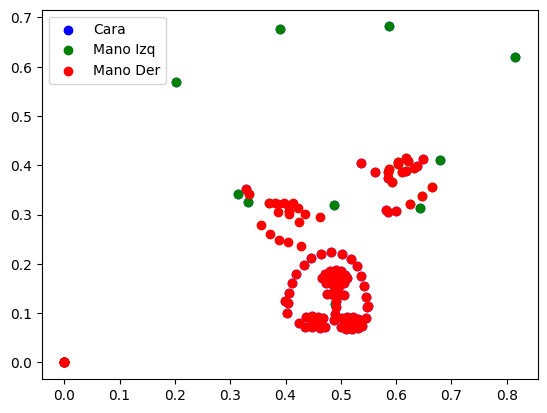

In [48]:
a,b,c  = 100 , 130, 250
face_idx = list(range(0, a))           
left_hand_idx = list(range(a, b))  
right_hand_idx = list(range(b, c))  

keypoints = kd[4000][0].clone()
frame = keypoints[0]  # (250, 2)
plt.scatter(frame[face_idx, 0], frame[face_idx, 1], color='blue', label='Cara')
plt.scatter(frame[left_hand_idx, 0], frame[left_hand_idx, 1], color='green', label='Mano Izq')
plt.scatter(frame[right_hand_idx, 0], frame[right_hand_idx, 1], color='red', label='Mano Der')
plt.legend()
